In [9]:
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [10]:
os.getcwd()

'/home/aayush/Kaggle-Humpback-Whale'

In [11]:
sample_size = 100
TRAIN_DIR = "train"

In [12]:
TRAIN_LABELLING = "train.csv"
all_labels = pd.read_csv(TRAIN_LABELLING).head(sample_size)
all_labels.shape

(100, 2)

In [13]:
all_labels.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [14]:
y = []
X = []
for _, row in all_labels.iterrows():
    y.append(row['Id'])
    path = os.path.join(TRAIN_DIR, row['Image'])
    X.append(plt.imread(path))

y = np.asarray(y)
len(X), y.shape

(100, (100,))

(100, (128, 128, 3))

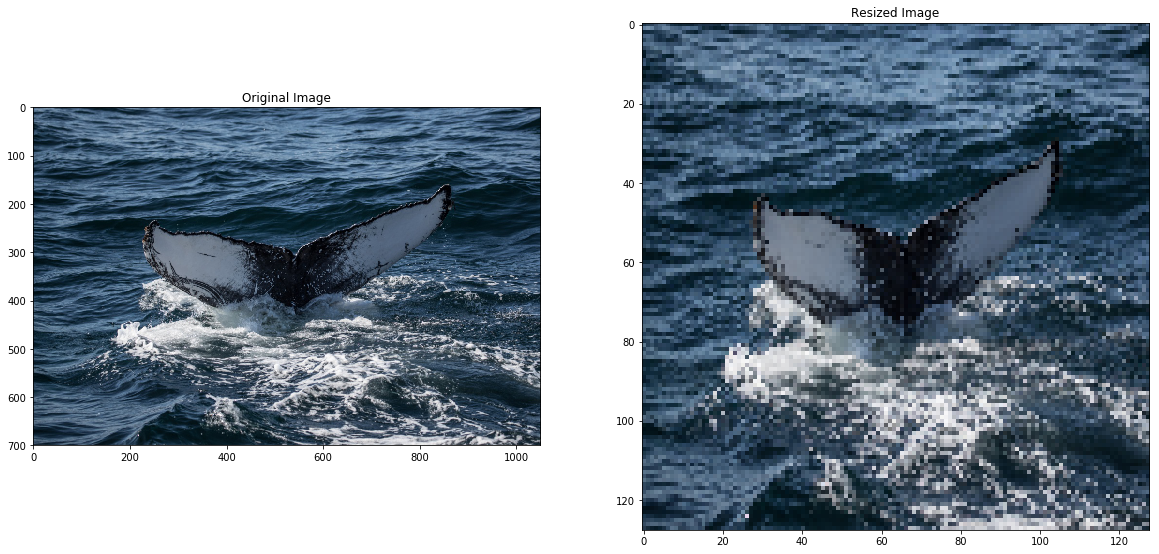

In [18]:
W = 128
H = 128
X_resized = []
for index,img in enumerate(X):
    X_resized.append(cv2.resize(img, (W,H)))

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.ravel()
ax[0].imshow(X[0])
ax[0].set_title('Original Image')
ax[1].imshow(X_resized[0])
ax[1].set_title('Resized Image')
len(X), X_resized[0].shape

TypeError: list indices must be integers, not tuple

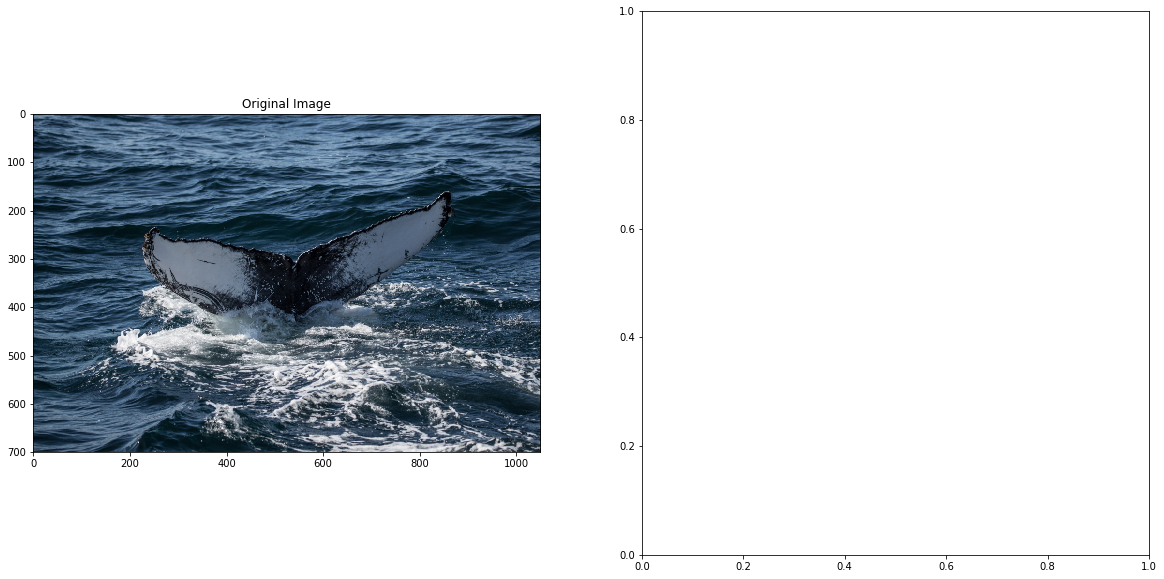

In [17]:
W = 700
H = 400
LEFT = 200
TOP = 100

X_cropped = []
for index,img in enumerate(X):
    X_cropped.append(X[LEFT:LEFT+W,TOP:TOP+H])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.ravel()
ax[0].imshow(X[0])
ax[0].set_title('Original Image')    
ax[1].imshow(X_cropped[0])
ax[1].set_title('Cropped Image')
len(X), X_cropped[0].shape